# Risk forecasting DNN model

### Imports

In [1]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from time import time

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Hyperparameters

In [3]:
# data params
SERIES_PERIOD = 'max'
SERIES_INTERVAL = '1d'
LOOKBACK_WINDOW = 10
PREDICTION_LEN = 1
TRAIN_TEST_SPLIT = TRAIN_VAL_SPLIT = 0.9

# general model params 
EPOCHS = 10
BATCH_SIZE = 32
NODES_PER_LAYER = 128

# active learning params
AL_ITERATIONS = 50
AL_SAMPLE = 100
AL_EPOCHS = 1

# progressive learning params
PRETRAINING_EPOCHS = 10
TUNING_EPOCHS = 10

### Data curation and manipulation

In [4]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# gather other variables
_open = sp500_history.Open[:-1]
_high = sp500_history.High[:-1]
_low = sp500_history.Low[:-1]
_volume = sp500_history.Volume[:-1]

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.min()) / _open.max(),
    'high': (_high - _high.min()) / _high.max(),
    'low': (_low - _low.min()) / _low.max(),
    'volume': (_volume - _volume.min()) / _volume.max(),

    'close': (close - close.min()) / close.max(),
    'returns': log_returns / log_returns.max(),  # already centred about 0
    'volatility': (volatility - volatility.min()) / volatility.max()
})

# remove NaN values and normalise
X.dropna(inplace=True)
X = X[list(X)].astype(np.float64)
X

,open,high,low,volume,close,returns,volatility
Date,,,,,,,
1950-01-10,0.003545,0.000077,0.000077,0.000129,0.000077,-0.026755,0.041578
1950-01-11,0.003557,0.000089,0.000090,0.000170,0.000090,0.032097,0.026233
1950-01-12,0.003488,0.000021,0.000021,0.000200,0.000021,-0.177951,0.085538
1950-01-13,0.003470,0.000002,0.000002,0.000231,0.000002,-0.049140,0.082654
1950-01-16,0.003480,0.000012,0.000013,0.000068,0.000013,0.027332,0.077147
...,...,...,...,...,...,...,...
2022-06-14,0.783331,0.780622,0.771755,0.360129,0.775310,-0.034505,0.118952
2022-06-15,0.783441,0.792945,0.775232,0.390524,0.786674,0.132215,0.183225
2022-06-16,0.775975,0.770245,0.757966,0.393718,0.760985,-0.301648,0.192826


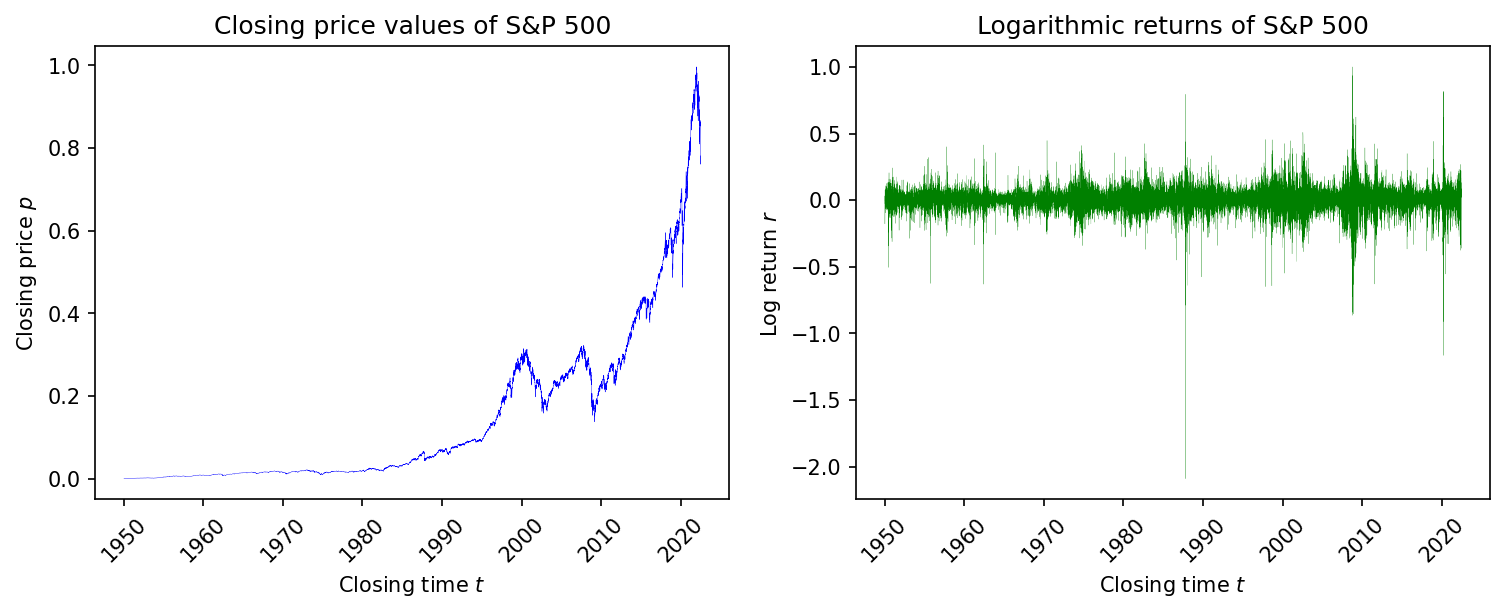

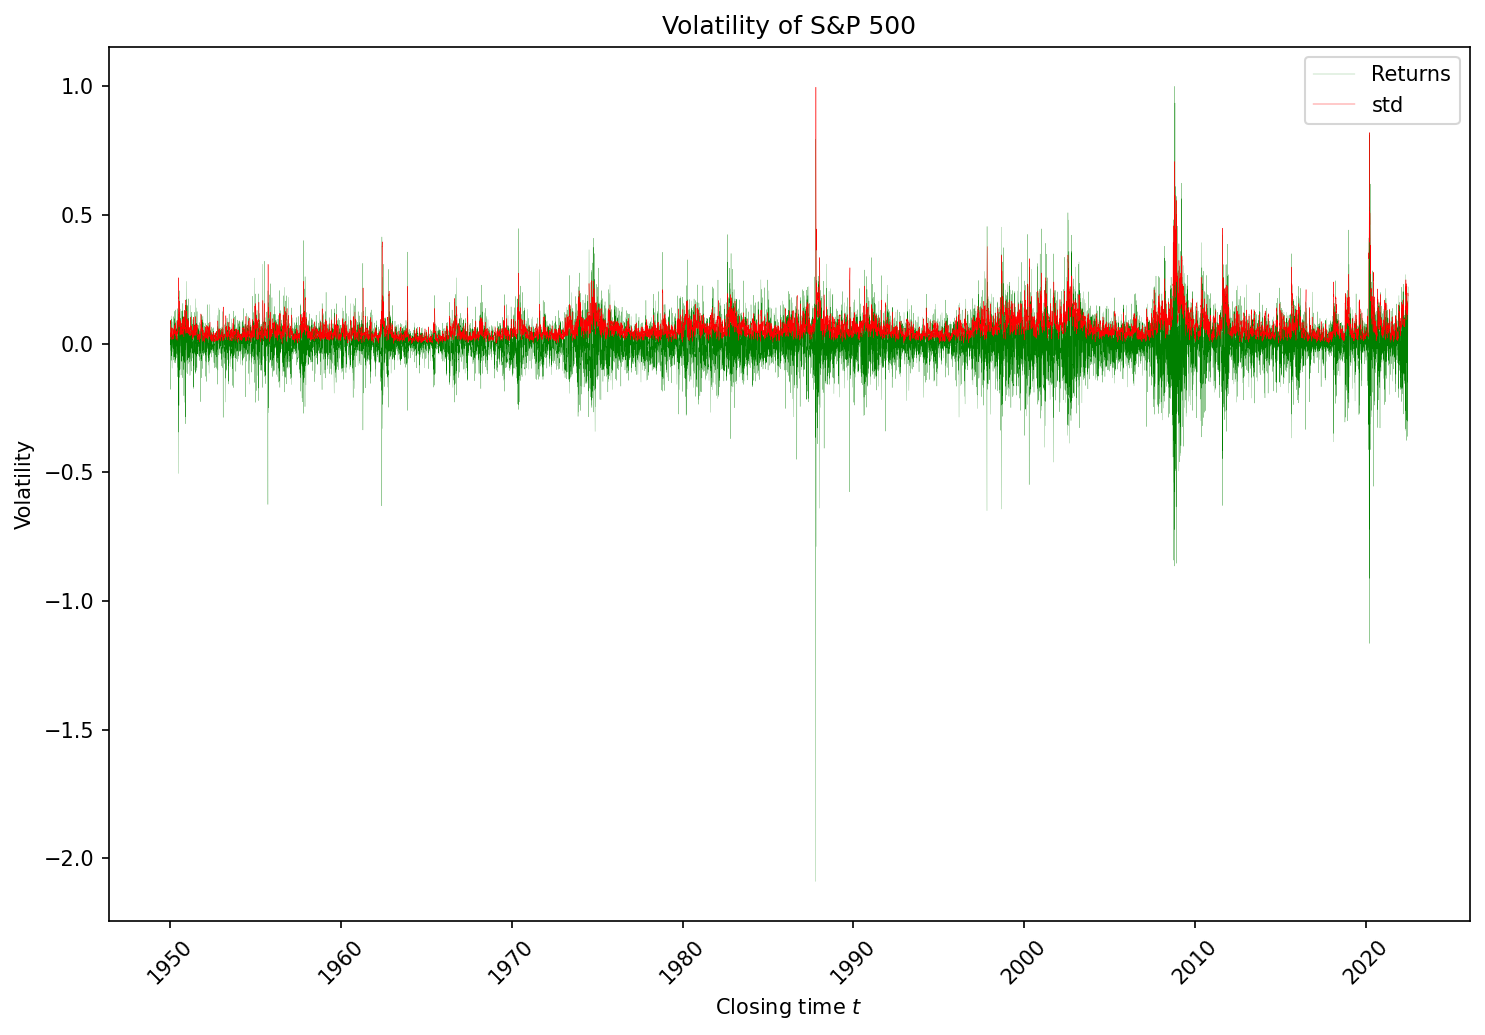

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.2, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.1, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
ax.plot(X.returns, linewidth=0.1, color='g', label='Returns')
ax.plot(X.volatility, linewidth=0.2, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [6]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the volatility value that comes at the next timestep after this series
X_data, y_data = [], []

for i in range(X.shape[0] - LOOKBACK_WINDOW - PREDICTION_LEN):
    X_data.append(X.values[i: i + LOOKBACK_WINDOW])
    y_data.append(X.volatility[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + PREDICTION_LEN])

# convert X, y to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# split into training and testing data
split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:split]
y_train = y_data[:split]
X_test = X_data[split:]
y_test = y_data[split:]

X_train, y_train = shuffle(X_train, y_train)

print(f"{TRAIN_TEST_SPLIT * 100:.0f}% training data, {(1 - TRAIN_TEST_SPLIT) * 100:.0f}% testing data")
print("Train:", X_train.shape, y_train.shape, '\nTest: ', X_test.shape, y_test.shape)

90% training data, 10% testing data
Train: (16397, 10, 7) (16397, 1) 
Test:  (1822, 10, 7) (1822, 1)


### Supervised layer-wise training

In [7]:
# supervised progressive training
def base_model(X, y):
    # define base model
    model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
        Dense(1, activation='linear')
    ])
    
    # compile and train base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])
    
    _start = time()
    hist = model.fit(X, y, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, hist.history, _timer


def progress_layers(model, X, y, history, ret_seq=False):
    # save then remove output layer
    output = model.layers[-1]
    model.pop()

    # halt training on existing layers
    for l in model.layers: l.trainable = False

    # add new layer and restore output layer
    model.add(
        LSTM(NODES_PER_LAYER, return_sequences=ret_seq, activation='tanh')
    )
    model.add(output)

    # retrain newest layer (+ output layer)
    _start = time()
    hist = model.fit(X, y, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    history['loss'].extend(hist.history['loss'])
    history['val_loss'].extend(hist.history['val_loss'])
    history['mse'].extend(hist.history['mse'])
    history['val_mse'].extend(hist.history['val_mse'])

    return model, history, _timer


def final_training(model, X, y):
    # remove encoder output layer
    model.pop()

    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # add final LSTM layer and regressor output layer to predict a single value
    model.add(LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'))
    model.add(Dense(1, activation='linear'))

    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    # train regressor
    _start = time()
    history = model.fit(X, y, epochs=TUNING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start
    
    return model, history.history, _timer

In [8]:
sup_model, history_sup_pretraining, pretrain_time_sup = base_model(X_train, y_train)
test_loss_1, test_acc_1 = sup_model.evaluate(X_test, y_test)

sup_model, history_sup_pretraining, timer = progress_layers(sup_model, X_train, y_train, history_sup_pretraining, ret_seq=True)
pretrain_time_sup += timer
test_loss_2, test_acc_2 = sup_model.evaluate(X_test, y_test)

sup_model, history_sup_tuning, tuning_time_sup = final_training(sup_model, X_train, y_train)

Epoch 1/10
52/52 [==============================] - 5s 37ms/step - loss: 0.0302 - mse: 0.0024 - val_loss: 0.0251 - val_mse: 0.0016
Epoch 2/10
52/52 [==============================] - 1s 25ms/step - loss: 0.0246 - mse: 0.0017 - val_loss: 0.0240 - val_mse: 0.0015
Epoch 3/10
52/52 [==============================] - 2s 29ms/step - loss: 0.0239 - mse: 0.0016 - val_loss: 0.0240 - val_mse: 0.0014
Epoch 4/10
52/52 [==============================] - 1s 25ms/step - loss: 0.0239 - mse: 0.0016 - val_loss: 0.0234 - val_mse: 0.0014
Epoch 5/10
52/52 [==============================] - 1s 29ms/step - loss: 0.0238 - mse: 0.0016 - val_loss: 0.0235 - val_mse: 0.0014
Epoch 6/10
52/52 [==============================] - 1s 29ms/step - loss: 0.0234 - mse: 0.0015 - val_loss: 0.0238 - val_mse: 0.0015
Epoch 7/10
52/52 [==============================] - 1s 25ms/step - loss: 0.0236 - mse: 0.0015 - val_loss: 0.0230 - val_mse: 0.0014
Epoch 8/10
52/52 [==============================] - 1s 26ms/step - loss: 0.0231 - m

In [9]:
# Supervised model architecture
sup_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           69632     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 332,929
Trainable params: 332,929
Non-trainable params: 0
_________________________________________________________________


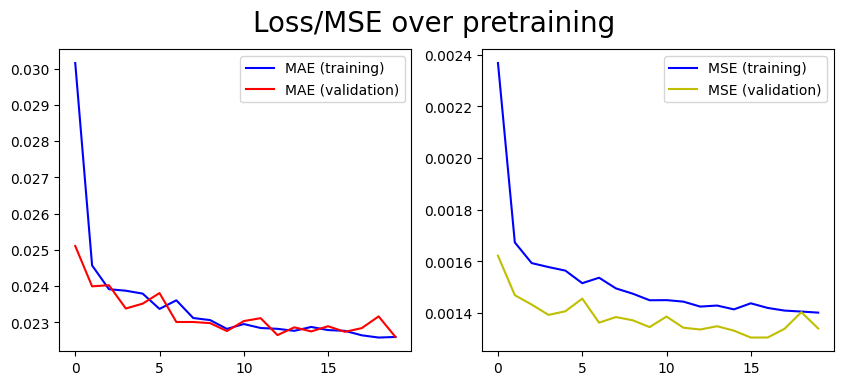

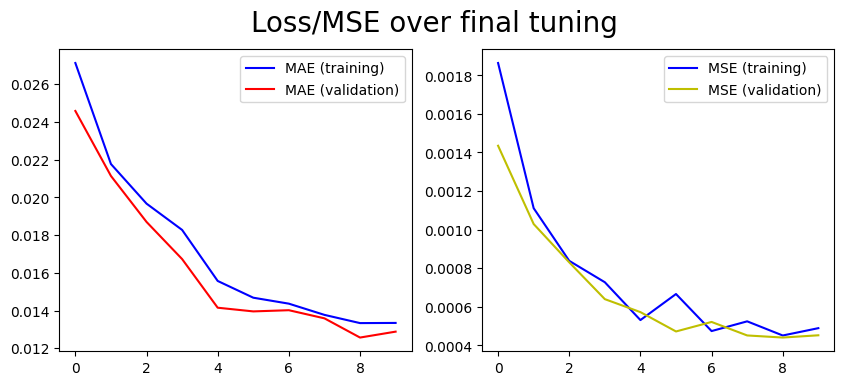

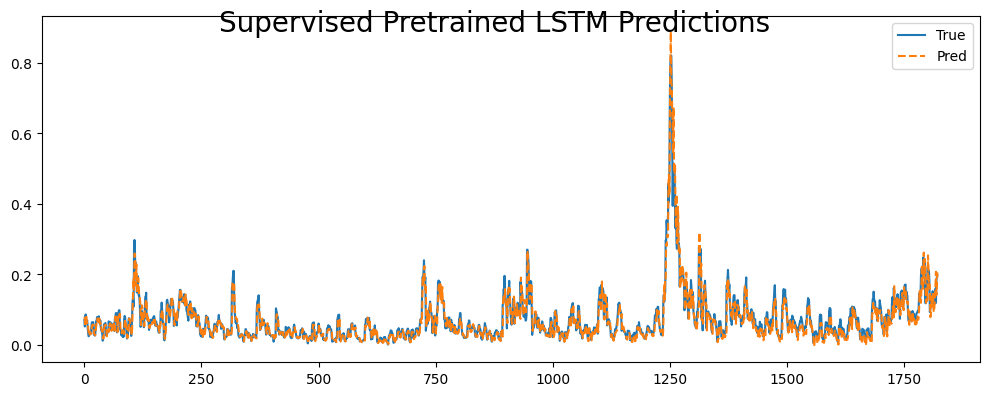

In [10]:
# pretraining loss plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
fig.suptitle("Loss/MSE over pretraining", fontsize=20)

ax[0].plot(history_sup_pretraining['loss'], color='b', label="MAE (training)")
ax[0].plot(history_sup_pretraining['val_loss'], color='r', label="MAE (validation)")
ax[0].legend(loc=0)

ax[1].plot(history_sup_pretraining['mse'], color='b', label="MSE (training)")
ax[1].plot(history_sup_pretraining['val_mse'], color='y', label="MSE (validation)")
ax[1].legend(loc=0)


# tuning loss plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
fig.suptitle("Loss/MSE over final tuning", fontsize=20)

ax[0].plot(history_sup_tuning['loss'], color='b', label="MAE (training)")
ax[0].plot(history_sup_tuning['val_loss'], color='r', label="MAE (validation)")
ax[0].legend(loc=0)

ax[1].plot(history_sup_tuning['mse'], color='b', label="MSE (training)")
ax[1].plot(history_sup_tuning['val_mse'], color='y', label="MSE (validation)")
ax[1].legend(loc=0)


# prediction plot
y_pred_sup = sup_model.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=100)
fig.suptitle("Supervised Pretrained LSTM Predictions", fontsize=20)

ax.plot(y_test, label='True')
ax.plot(y_pred_sup, linestyle='--', label='Pred')
ax.legend(loc=0)

plt.tight_layout()
plt.show()

In [11]:
# metrics
mae = np.abs(np.subtract(y_test, y_pred_sup)).mean()
mse = np.square(np.subtract(y_test, y_pred_sup)).mean()
mape = np.abs((y_test - y_pred_sup) / y_test).mean() * 100

_msle = pd.DataFrame(np.subtract(np.log(y_test + 1), np.log(y_pred_sup + 1)))
_msle.dropna(inplace=True)
msle = float(np.square(_msle).mean())

print(f"mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")
print(f"pretraining time = {pretrain_time_sup:.2f}s, final tuning time = {tuning_time_sup:.2f}")

mae = 0.01503; mse = 0.00058; msle = 0.00043; mape = 25.23589%
pretraining time = 35.93s, final tuning time = 24.01


### Unsupervised layer-wise training

In [12]:
# unsupervised layer-wise training
def base_autoencoder(X):
    # define base model
    model = Sequential([
        LSTM(NODES_PER_LAYER, activation='tanh', return_sequences=True, input_shape=(X.shape[1:])),
        TimeDistributed(Dense(X.shape[2]))
    ])

    # compile base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mse', optimizer=optim)

    # train model as an autoencoder that recreates its inputs (minimising mse between input and ouput)
    _start = time()
    hist = model.fit(X, X, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, hist.history, _timer


def add_autoencoder(model, X, history):
    # stash output layer
    output = model.layers[-1]
    model.pop()

    # fix weights of autoencoder layers (note, this is redundant if `evaluate_regression` called beforehand)
    for l in model.layers: l.trainable = False

    # add new autoencoder layer and read output layer
    model.add(LSTM(NODES_PER_LAYER, activation='tanh', return_sequences=True))
    model.add(output)

    # train new autoencoder layer
    _start = time()
    hist = model.fit(X, X, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    # collect metrics
    history['loss'].extend(hist.history['loss'])
    history['val_loss'].extend(hist.history['val_loss'])

    return model, history, _timer


def build_final_model(model, X, y):
    # remove encoder output layer
    model.pop()

    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # add final LSTM layer and regressor output layer to predict a single value
    model.add(LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'))
    model.add(Dense(1, activation='linear'))

    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    # train regressor
    _start = time()
    history = model.fit(X, y, epochs=TUNING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, history.history, _timer

In [13]:
encoder, enc_history, total_enc_time = base_autoencoder(X_train)
encoder, enc_history, timer = add_autoencoder(encoder, X_train, enc_history)
total_enc_time += timer

regressor, reg_history, total_reg_time = build_final_model(encoder, X_train, y_train)

Epoch 1/10
52/52 [==============================] - 3s 28ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 2/10
52/52 [==============================] - 1s 29ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/10
52/52 [==============================] - 1s 24ms/step - loss: 0.0010 - val_loss: 7.6671e-04
Epoch 4/10
52/52 [==============================] - 2s 31ms/step - loss: 5.6318e-04 - val_loss: 4.4280e-04
Epoch 5/10
52/52 [==============================] - 2s 30ms/step - loss: 3.4112e-04 - val_loss: 2.9089e-04
Epoch 6/10
52/52 [==============================] - 1s 29ms/step - loss: 2.3406e-04 - val_loss: 2.0883e-04
Epoch 7/10
52/52 [==============================] - 1s 29ms/step - loss: 1.6833e-04 - val_loss: 1.5544e-04
Epoch 8/10
52/52 [==============================] - 1s 29ms/step - loss: 1.2614e-04 - val_loss: 1.1881e-04
Epoch 9/10
52/52 [==============================] - 1s 21ms/step - loss: 9.6449e-05 - val_loss: 9.2451e-05
Epoch 10/10
52/52 [==============================] - 1s 2

In [14]:
# Unsupervised model architecture
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 128)           69632     
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           131584    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 332,929
Trainable params: 332,929
Non-trainable params: 0
_________________________________________________________________


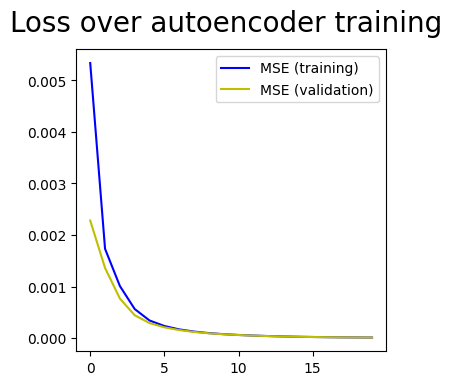

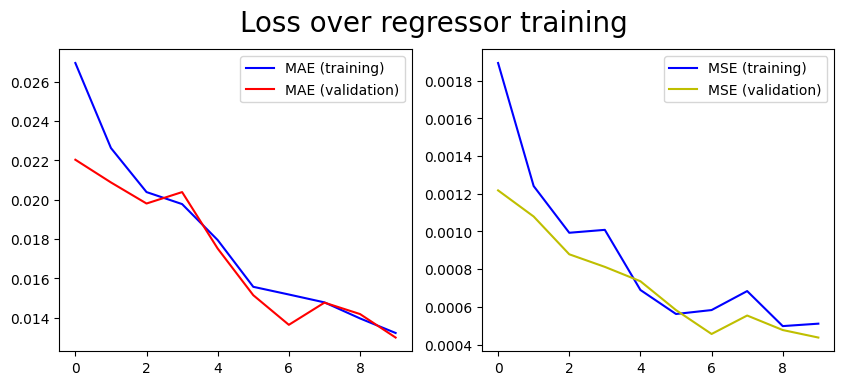

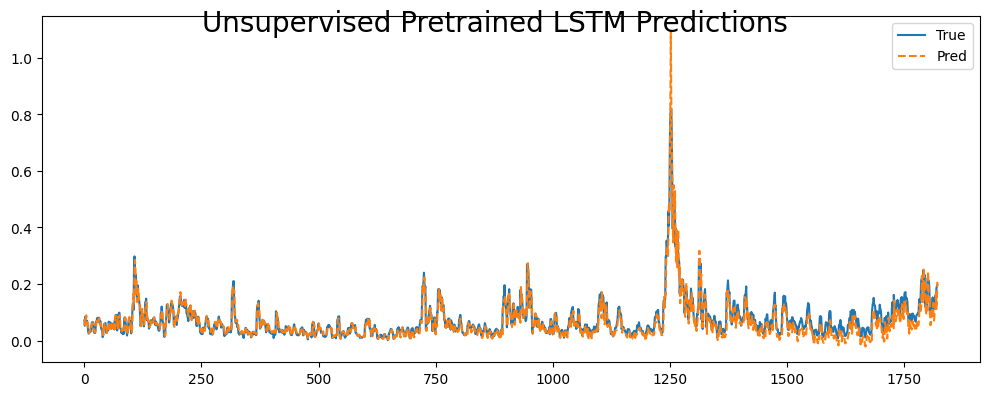

In [15]:
# autoencoder loss plots
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
fig.suptitle("Loss over autoencoder training", fontsize=20)

ax.plot(enc_history['loss'], color='b', label="MSE (training)")
ax.plot(enc_history['val_loss'], color='y', label="MSE (validation)")
ax.legend(loc=0)


# regressor loss plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
fig.suptitle("Loss over regressor training", fontsize=20)

ax[0].plot(reg_history['loss'], color='b', label="MAE (training)")
ax[0].plot(reg_history['val_loss'], color='r', label="MAE (validation)")
ax[0].legend(loc=0)

ax[1].plot(reg_history['mse'], color='b', label="MSE (training)")
ax[1].plot(reg_history['val_mse'], color='y', label="MSE (validation)")
ax[1].legend(loc=0)


# prediction plot
y_pred_unsup = regressor.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=100)
fig.suptitle("Unsupervised Pretrained LSTM Predictions", fontsize=20)

ax.plot(y_test, label='True')
ax.plot(y_pred_unsup, linestyle='--', label='Pred')
ax.legend(loc=0)

plt.tight_layout()
plt.show()

In [16]:
mae = np.abs(np.subtract(y_test, y_pred_unsup)).mean()
mse = np.square(np.subtract(y_test, y_pred_unsup)).mean()
mape = np.abs((y_test - y_pred_unsup) / y_test).mean() * 100

_msle = pd.DataFrame(np.subtract(np.log(y_test + 1), np.log(y_pred_unsup + 1)))
_msle.dropna(inplace=True)
msle = float(np.square(_msle).mean())

print(f"mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")
print(f"autoencoder training time = {total_enc_time:.2f}s, regressor training time = {total_reg_time:.2f}")

mae = 0.01834; mse = 0.00076; msle = 0.00059; mape = 32.04967%
autoencoder training time = 33.84s, regressor training time = 44.28


### Active Learning

In [33]:
# GSx sampling for initial seed pool
def initial_selection(X, y, k=AL_SAMPLE):
    # select first sample as closest to centroid of all training samples
    centroid = np.mean(X, axis=0)

    # compute euclidean distance
    distances = np.max(np.linalg.norm(X - centroid, axis=2), axis=1)

    # select instances with smallest distance
    train_indices = np.argpartition(distances, k)[:k]
    X_instances = X[train_indices]
    y_instances = y[train_indices]

    # gather remaining instances
    val_indices = np.setdiff1d(range(X.shape[0]), train_indices)
    X_instances_val = X[val_indices]
    y_instances_val = y[val_indices]

    return X_instances, y_instances, X_instances_val, y_instances_val


# GSy sampling for selecting instances to add to training pool
def select_instances(model, X_t, y_t, X_v, y_v, k=AL_SAMPLE):
    # generate outputs y over validation set
    y_pred = model.predict(X_v)
    
    # for each prediction, find the minimum distance to an output in the training set
    _y_pred = y_pred.squeeze(1)
    _y_t = y_t.squeeze(1)
    distances = np.min(np.abs(_y_pred[:, np.newaxis] - _y_t), axis=1)

    # select new training instances as those furthest from training set outputs
    train_indices = np.argpartition(distances, -k)[-k:]
    val_indices = np.setdiff1d(range(X_v.shape[0]), train_indices)

    X_t = np.append(X_t, X_v[train_indices], axis=0)
    y_t = np.append(y_t, y_v[train_indices], axis=0)
    X_v = X_v[val_indices]
    y_v = y_v[val_indices]

    return X_t, y_t, X_v, y_v

In [34]:
# build RNN/LSTM architecture
lstm_model = Sequential([
    LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh'),
    LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'),
    Dense(1, activation='linear')
])

adam_opt = Adam(learning_rate=0.001, decay=1e-5)
lstm_model.compile(loss='mae', optimizer=adam_opt, metrics=['mse'])

In [35]:
# active learning training
histories = {}

# initial training over seed dataset
X_pool, y_pool, X_val, y_val = initial_selection(X_train, y_train)
history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT, verbose=False)

# store metrics
histories.update({
    'loss': [np.min(history.history['loss'])],
    'mse': [np.min(history.history['mse'])],
    'val_loss': [np.min(history.history['val_loss'])],
    'val_mse': [np.min(history.history['val_mse'])]
})

# iteratively train model
for it in range(AL_ITERATIONS):
    print(f"Iteration {it+1}/{AL_ITERATIONS}; pool = {X_pool.shape[0]}, val = {X_val.shape[0]}")
    if X_val.shape[0] >= AL_SAMPLE:
        # use GSy method to select samples to add to the training pool
        X_pool, y_pool, X_val, y_val = select_instances(lstm_model, X_pool, y_pool, X_val, y_val)

        # train model over pool
        history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
        
        # store metrics
        histories['loss'].append(np.min(history.history['loss']))
        histories['mse'].append(np.min(history.history['mse']))
        histories['val_loss'].append(np.min(history.history['val_loss']))
        histories['val_mse'].append(np.min(history.history['val_mse']))
    else:
        break

Iteration 0/50; pool = 100, val = 16297
1/1 [==============================] - 0s 69ms/step - loss: 0.0150 - mse: 2.8574e-04 - val_loss: 0.0240 - val_mse: 0.0011
Iteration 1/50; pool = 200, val = 16197
1/1 [==============================] - 0s 74ms/step - loss: 0.0087 - mse: 1.1062e-04 - val_loss: 0.0347 - val_mse: 0.0036
Iteration 2/50; pool = 300, val = 16097
2/2 [==============================] - 0s 108ms/step - loss: 0.0087 - mse: 1.2656e-04 - val_loss: 0.0345 - val_mse: 0.0033
Iteration 3/50; pool = 400, val = 15997
2/2 [==============================] - 0s 99ms/step - loss: 0.0075 - mse: 1.0022e-04 - val_loss: 0.0351 - val_mse: 0.0036
Iteration 4/50; pool = 500, val = 15897
2/2 [==============================] - 0s 101ms/step - loss: 0.0090 - mse: 1.2001e-04 - val_loss: 0.0432 - val_mse: 0.0062
Iteration 5/50; pool = 600, val = 15797
3/3 [==============================] - 0s 57ms/step - loss: 0.0081 - mse: 1.1038e-04 - val_loss: 0.0453 - val_mse: 0.0061
Iteration 6/50; pool = 700

In [36]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 128)           69632     
                                                                 
 lstm_19 (LSTM)              (None, 10, 128)           131584    
                                                                 
 lstm_20 (LSTM)              (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 332,929
Trainable params: 332,929
Non-trainable params: 0
_________________________________________________________________


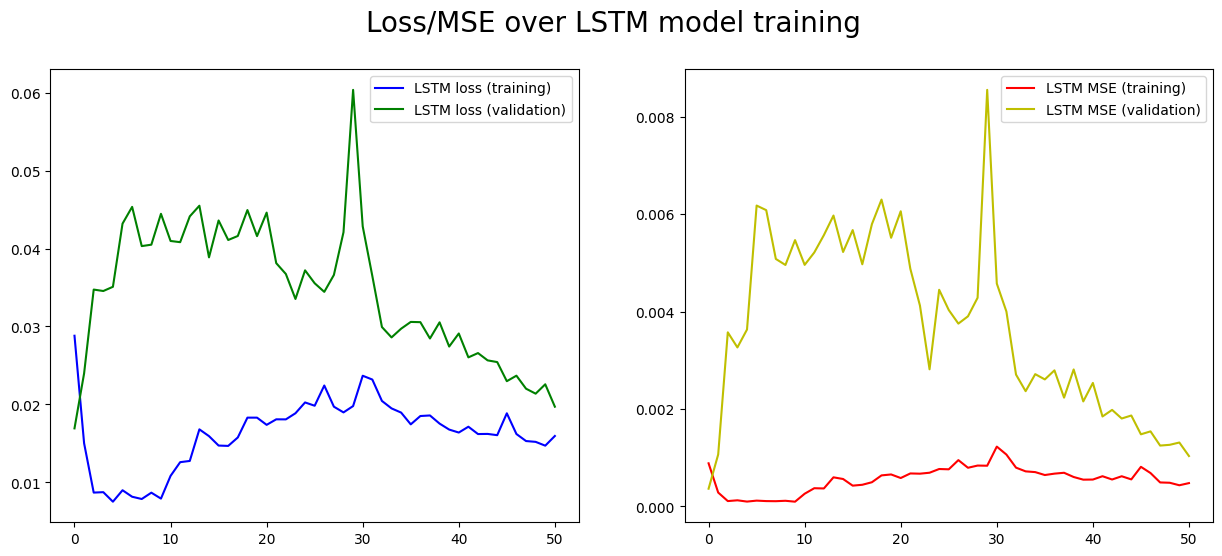

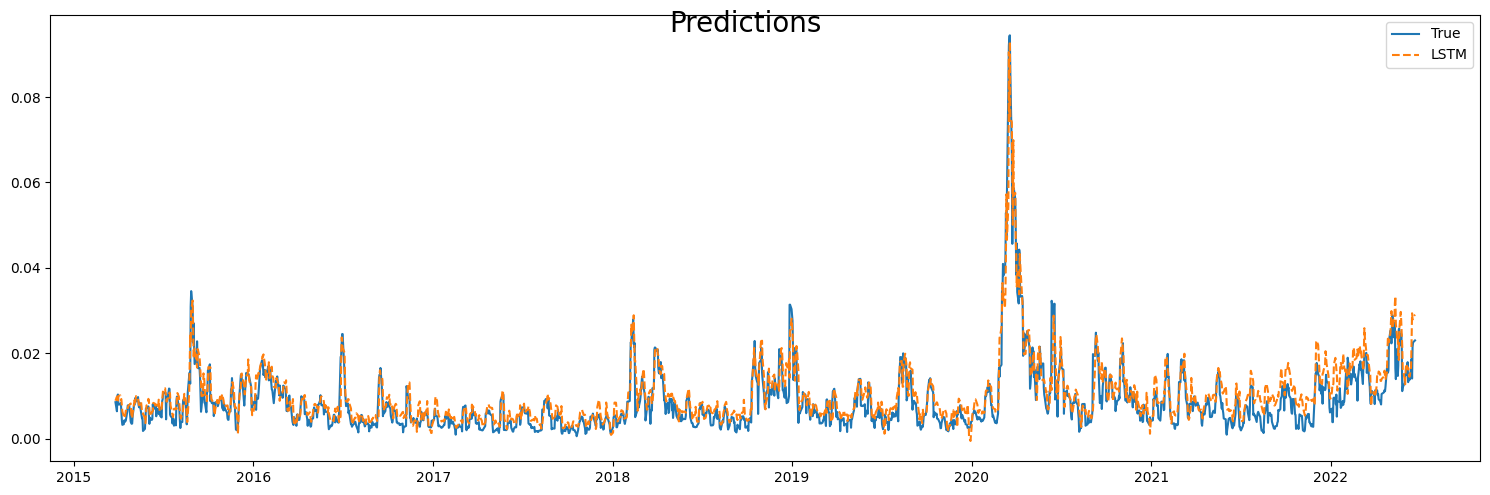

In [37]:
# training loss plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=100)
fig.suptitle("Loss/MSE over LSTM model training", fontsize=20)

ax[0].plot(histories['loss'], color='b', label="LSTM loss (training)")
ax[0].plot(histories['val_loss'], color='g', label="LSTM loss (validation)")
ax[0].legend(loc=0)

ax[1].plot(histories['mse'], color='r', label="LSTM MSE (training)")
ax[1].plot(histories['val_mse'], color='y', label="LSTM MSE (validation)")
ax[1].legend(loc=0)

# prediction plot
y_pred_al = lstm_model.predict(X_test) * volatility.max() + volatility.min()
y_test_unscaled = y_test * volatility.max() + volatility.min()
y_test_plot = pd.Series(y_test_unscaled.squeeze(1), index=X.volatility[split + LOOKBACK_WINDOW + 1:].keys())

fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=100)
fig.suptitle("Predictions", fontsize=20)

y_pred_plot = pd.Series(y_pred_al.squeeze(1), index=X.volatility[split + LOOKBACK_WINDOW + 1:].keys())

ax.plot(y_test_plot, label='True')
ax.plot(y_pred_plot, linestyle='--', label='LSTM')
ax.legend(loc=0)

plt.tight_layout()
plt.show()

In [38]:
mae = np.abs(np.subtract(y_test, y_pred_al)).mean()
mse = np.square(np.subtract(y_test, y_pred_al)).mean()
mape = np.abs((y_test - y_pred_al) / y_test).mean() * 100

_msle = pd.DataFrame(np.subtract(np.log(y_test + 1), np.log(y_pred_al + 1)))
_msle.dropna(inplace=True)
msle = float(np.square(_msle).mean())

print(f"mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")

mae = 0.06274; mse = 0.00803; msle = 0.00615; mape = 82.79756%


### Baseline comparison model (basic non-active, non-layer-wise training)

In [39]:
# comparative model to progressively trained model
comp_model = Sequential([
    LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh'),
    LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'),
    Dense(1, activation='linear')
])

# compile and train comparison model
optim = Adam(learning_rate=0.001, decay=1e-5)
comp_model.compile(loss='mae', optimizer=optim, metrics=['mse'])

# compute equivalent no. epochs as used in the progressive learning methods
training_rounds = len(regressor.layers) - 2
epochs = PRETRAINING_EPOCHS * training_rounds + TUNING_EPOCHS
print(f"Baseline model training over {epochs} epochs\n")

# train and evaluate 
start_comp = time()
hist = comp_model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
total_time_comp = time() - start_comp
history_comp = hist.history

test_loss, test_acc = comp_model.evaluate(X_test, y_test)

Baseline model training over 30 epochs

Epoch 1/30
52/52 [==============================] - 6s 53ms/step - loss: 0.0266 - mse: 0.0018 - val_loss: 0.0238 - val_mse: 0.0014
Epoch 2/30
52/52 [==============================] - 2s 36ms/step - loss: 0.0227 - mse: 0.0013 - val_loss: 0.0225 - val_mse: 0.0011
Epoch 3/30
52/52 [==============================] - 2s 36ms/step - loss: 0.0223 - mse: 0.0013 - val_loss: 0.0220 - val_mse: 0.0012
Epoch 4/30
52/52 [==============================] - 3s 57ms/step - loss: 0.0212 - mse: 0.0011 - val_loss: 0.0202 - val_mse: 9.4206e-04
Epoch 5/30
52/52 [==============================] - 3s 57ms/step - loss: 0.0201 - mse: 0.0010 - val_loss: 0.0196 - val_mse: 9.0270e-04
Epoch 6/30
52/52 [==============================] - 2s 36ms/step - loss: 0.0184 - mse: 8.0756e-04 - val_loss: 0.0165 - val_mse: 6.4255e-04
Epoch 7/30
52/52 [==============================] - 2s 36ms/step - loss: 0.0159 - mse: 5.7647e-04 - val_loss: 0.0143 - val_mse: 5.2370e-04
Epoch 8/30
52/52 [=

In [40]:
# Comparison model architecture
comp_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 10, 128)           69632     
                                                                 
 lstm_22 (LSTM)              (None, 10, 128)           131584    
                                                                 
 lstm_23 (LSTM)              (None, 128)               131584    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 332,929
Trainable params: 332,929
Non-trainable params: 0
_________________________________________________________________


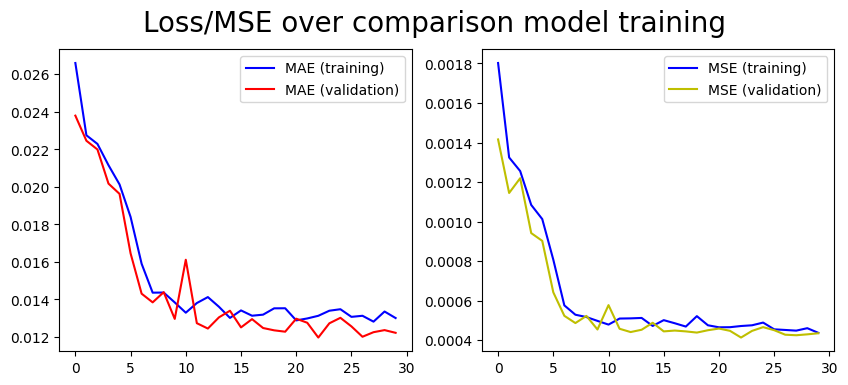

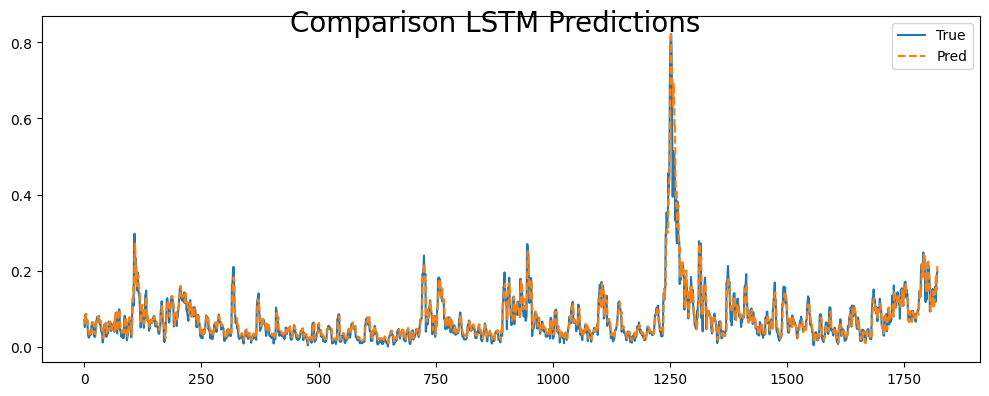

In [41]:
# training loss plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
fig.suptitle("Loss/MSE over comparison model training", fontsize=20)

ax[0].plot(history_comp['loss'], color='b', label="MAE (training)")
ax[0].plot(history_comp['val_loss'], color='r', label="MAE (validation)")
ax[0].legend(loc=0)

ax[1].plot(history_comp['mse'], color='b', label="MSE (training)")
ax[1].plot(history_comp['val_mse'], color='y', label="MSE (validation)")
ax[1].legend(loc=0)


# prediction plot
y_pred_comp = comp_model.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=100)
fig.suptitle("Comparison LSTM Predictions", fontsize=20)

ax.plot(y_test, label='True')
ax.plot(y_pred_comp, linestyle='--', label='Pred')
ax.legend(loc=0)

plt.tight_layout()
plt.show()

In [42]:
# metrics
mae = np.abs(np.subtract(y_test, y_pred_comp)).mean()
mse = np.square(np.subtract(y_test, y_pred_comp)).mean()
mape = np.abs((y_test - y_pred_comp) / y_test).mean() * 100

_msle = pd.DataFrame(np.subtract(np.log(y_test + 1), np.log(y_pred_comp + 1)))
_msle.dropna(inplace=True)
msle = float(np.square(_msle).mean())

print(f"mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")
print(f"training time = {total_time_comp:.2f}s")

mae = 0.01455; mse = 0.00060; msle = 0.00042; mape = 29.17044%
training time = 66.02s
